In [2]:
#import lines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


In [3]:
#inpsect data

sheet1 = pd.read_excel("online_retail_II.xlsx", sheet_name='Year 2009-2010')
sheet2 = pd.read_excel("online_retail_II.xlsx", sheet_name='Year 2010-2011')

retail_data = pd.concat([sheet1, sheet2], ignore_index=True)
retail_data.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# data cleaning
rows, cols = retail_data.shape

# Count NA per column
na_per_column = retail_data.isna().sum()
print("NA Count per Column:")
print(na_per_column)

# data standardisation
# remove all characters from "Invoice" and "StockCode"
# missing description from 2928 rows 
# missing customer ID for 107927 rows 

unique_stock = retail_data['StockCode'].unique()

# remove zeroes from the sale

no_zero_sale = retail_data[retail_data["Price"] != 0]

# remove POST entries

filtered2 = no_zero_sale[~no_zero_sale["Description"].str.contains("POSTAGE", case=False, na=False)]

filtered2.to_csv("cleaned_WITH_refund_sales.csv")

# 'C' code means cancellation and then results in a negative quantity

string_invoices = filtered2[filtered2["Invoice"].apply(lambda x: isinstance(x, str))]


# do we want to remove any rows with this value? 

filtered3 = filtered2.drop(string_invoices.index)

filtered3.to_csv("cleaned_retail_data.csv")

# remove any StockCode that says "TEST001" - 10 Instances found 





# Invoice codes with same digits but different letters signify different colours/versions of the same ITEM / CATEGORY
# Reasonable Assumptions: Blank Customer ID are just Guest Order(s) no previous purchase history 
# Can Impute by replacing all blanks with "Guest" + Number 

filtered3.head()




NA Count per Column:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# Convert 'InvoiceDate' to datetime

from statsmodels.tsa.seasonal import seasonal_decompose
filtered3['InvoiceDate'] = pd.to_datetime(filtered3['InvoiceDate'])

# Set 'InvoiceDate' as the index
filtered3['Total_Sale'] = filtered3['Price'] * filtered3['Quantity']

filtered3.set_index('InvoiceDate', inplace=True)


/var/folders/4r/krw46gbs0qb49j9lv1ybjb6w0000gn/T/ipykernel_16791/1549667651.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_data = filtered3.resample('W').sum()


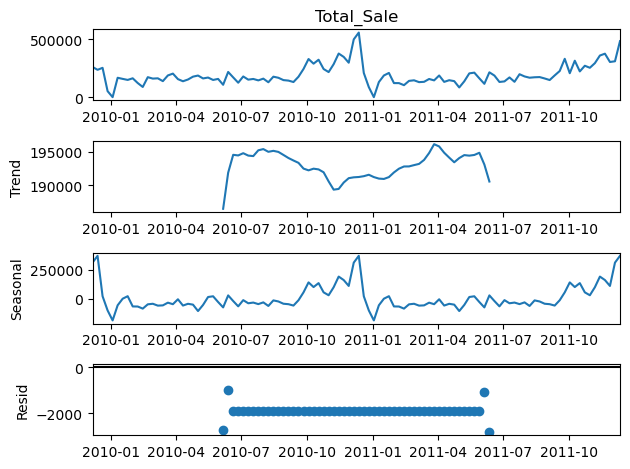

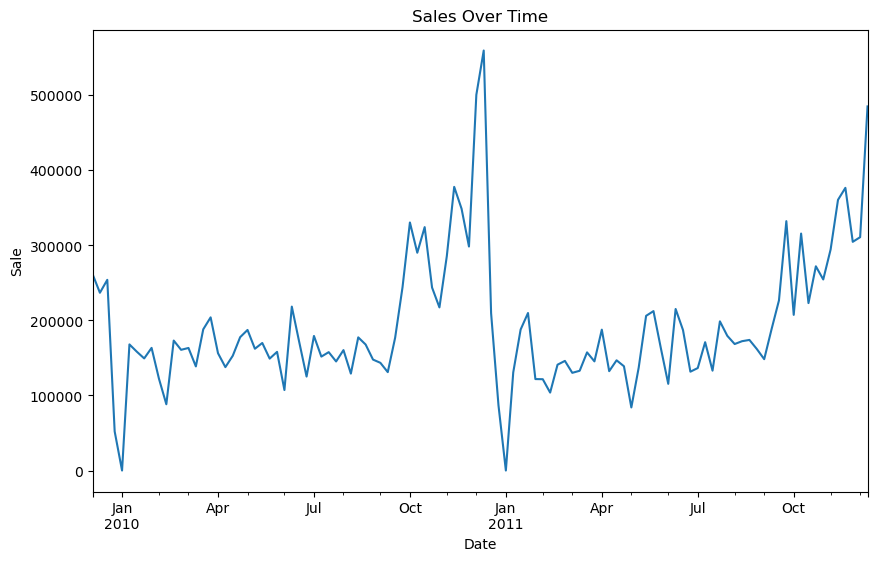

In [6]:
# Resample weekly and sum prices
weekly_data = filtered3.resample('W').sum()

# Perform Seasonal Decomposition
result = seasonal_decompose(weekly_data['Total_Sale'], model='additive')
result.plot()
plt.savefig('seasonal_decompose.jpeg')
plt.show()


weekly_data['Total_Sale'].plot(figsize=(10, 6))
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sale')
plt.savefig('total_sales_over_time.jpeg')
plt.show()

# Export the Graphs 



In [64]:
#grouping by stockcode to see all the duplicates

grouped = filtered3.groupby('StockCode')

grouped.head(10)

#filtered3.head(10)

# TOP 10 StockCode by Total Sale

sorted_stockcodes = filtered3.sort_values(by="Total_Sale", ascending=False)

grouped_stockcodes = sorted_stockcodes.groupby("StockCode")['Total_Sale'].sum().reset_index()
grouped_stockcodes = grouped_stockcodes.sort_values(by="Total_Sale", ascending=False)

# remove M as an anomaly
grouped_stockcodes = grouped_stockcodes[grouped_stockcodes["StockCode"] != "M"]

# top 10 stockcode
grouped_stockcodes.head(10)
Top10_StockCodes = list(grouped_stockcodes['StockCode'][0:10])

# reverse searching it back in the original dataset
top10_items = filtered3[filtered3['StockCode'].isin(Top10_StockCodes)][['StockCode','Description']]

# combining the item description with the stockcode

top10_items['StockCode'] = pd.Categorical(
    top10_items['StockCode'],
    categories=Top10_StockCodes,
    ordered=True
)

sorted_filtered_descriptions = top10_items.sort_values(by='StockCode')
sorted_filtered_descriptions = sorted_filtered_descriptions.drop_duplicates()





                    StockCode                         Description
InvoiceDate                                                      
2010-12-06 13:34:00     22423            REGENCY CAKESTAND 3 TIER
2011-08-18 17:43:00    85123A  WHITE HANGING HEART T-LIGHT HOLDER
2011-12-08 16:30:00    85123A  CREAM HANGING HEART T-LIGHT HOLDER
2011-05-10 12:20:00    85099B             JUMBO BAG RED RETROSPOT
2010-03-05 14:51:00    85099B         JUMBO BAG RED WHITE SPOTTY 
2010-04-12 13:22:00    85099B            RED RETROSPOT JUMBO BAG 
2011-12-09 09:15:00     23843         PAPER CRAFT , LITTLE BIRDIE
2011-06-14 12:45:00     47566                       PARTY BUNTING
2011-11-20 12:45:00     84879       ASSORTED COLOUR BIRD ORNAMENT
2010-11-08 11:54:00     22086     PAPER CHAIN KIT 50'S CHRISTMAS 
2011-04-26 10:32:00     79321                       CHILLI LIGHTS
2011-11-01 13:44:00     23166      MEDIUM CERAMIC TOP STORAGE JAR
2010-04-29 13:54:00     22197                SMALL POPCORN HOLDER
2011-12-07

In [66]:
# Top 10 Countries of Sale 

country_sorted_df = filtered3.sort_values(by="Total_Sale", ascending=False)

grouped_country = country_sorted_df.groupby("Country")['Total_Sale'].sum().reset_index()
grouped_country = grouped_country.sort_values(by="Total_Sale", ascending=False)

grouped_country.head(10)

,Country,Total_Sale
40,United Kingdom,1.752718e+07
11,EIRE,6.644318e+05
26,Netherlands,5.501493e+05
15,Germany,3.920313e+05
14,France,3.319146e+05
0,Australia,1.696181e+05
34,Spain,1.002515e+05
36,Switzerland,9.427029e+04
35,Sweden,8.813272e+04
10,Denmark,6.856019e+04


In [75]:
# HOLIDAY PERIOD FILTERING, SEE IF FINDINGS ARE ANY DIFFERENT


holiday_period_data = filtered3[
    (filtered3.index.month >= 10) &
    (filtered3.index.month <= 12)
]
non_holiday_period_data = filtered3[
    (filtered3.index.month < 10)
]
non_holiday_period_data.to_csv("normal_period_sales.csv")

# average sales of holiday period
holiday_avg_sale = holiday_period_data['Total_Sale'].mean()
# average sales of non-holiday period
nonholiday_avg_sale = non_holiday_period_data['Total_Sale'].mean()

print(holiday_avg_sale)
print(nonholiday_avg_sale)



19.16660065219627
20.13455383794717


In [ ]:
# OPTIONAL:
# top 10 products in the UK, vs. top 10 products outside of the UK 



In [93]:
# Check for Dynamic Pricing / Same Products Different Price 

# For Loop to detect same StockCode but different Unit Price
# Price and StockCode 

# list of unique Stock Codes 
stockcode_list = filtered3['StockCode'].unique().tolist()

for item in stockcode_list[0:1]:
    init_price = filtered3[filtered3['StockCode']  == item]['Price']
    
# We find that Dynamic Pricing DOES exist 

# now what to do with this information 


DatetimeIndex(['2009-12-01 07:45:00', '2009-12-01 12:55:00',
               '2009-12-01 13:38:00', '2009-12-01 13:47:00',
               '2009-12-01 14:28:00', '2009-12-01 14:50:00',
               '2009-12-01 17:28:00', '2009-12-02 10:00:00',
               '2009-12-02 12:09:00', '2009-12-02 15:41:00',
               ...
               '2011-12-05 11:58:00', '2011-12-05 13:10:00',
               '2011-12-05 17:24:00', '2011-12-06 14:50:00',
               '2011-12-06 15:32:00', '2011-12-07 14:34:00',
               '2011-12-08 09:28:00', '2011-12-08 10:53:00',
               '2011-12-09 10:03:00', '2011-12-09 10:26:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=551, freq=None)


In [ ]:
# SAMPLE RECOMMENDATION
# Generate a #sales vs. #unit price graph for top 3 most sold items in gross sales across the observation period
# find a sweet spot where these two numbers seem to agree the best
# find the percentage increase and forecast? 